### 🧩 Generating the Patch Sampling DataFrame

This notebook builds a patch-level DataFrame used to extract informative image crops (patches) from RCC WSIs. The resulting `.parquet` file is used as input for the training phase. The notebook performs the following steps:

1. **Load the configuration** from `preprocessing.yaml`, resolving environment paths and parameters.
2. **Select the active stage** (`debug` or `training`) and extract patching/sampling parameters (patch size, stride, seed, patients per class).
3. **Load and filter the metadata**, keeping only entries with valid XML annotations or ROI files.
4. **Optionally downsample patients**, selecting a subset per class if sampling is enabled.
5. **Build reusable ROI maps** for each subtype, mapping patients to annotated areas (either XML or ROI).
6. **Split patients into train/val/test**, based on configured proportions and a random seed.
7. **Sample patches per subtype and split**, ensuring balanced class distribution and extracting spatial coordinates within annotated areas.
8. **Build and export the patch DataFrame**, saving it as a `.parquet` file inside a uniquely versioned dataset folder.
9. **Log metadata and register the dataset**, writing a version descriptor `.md` and updating a central CSV registry.
10. **Run integrity checks**, including patch counts per class/split, duplicated patient IDs, and subtype overlaps.
11. **Summarize used WSIs**, printing dimensions and file sizes to ensure correctness.

---

| #  | **Section (Markdown Title)** | **Main Content (Documented Classes/Functions)**                                                                      | **Output**                |
| -- | ---------------------------- | -------------------------------------------------------------------------------------------------------------------- | ------------------------- |
| 1  | **Config & Path Loader**     | `ConfigLoader`, `PathResolver`: load `preprocessing.yaml`, resolve all placeholders and paths                        | `CFG`, `PATHS`            |
| 2  | **Stage Parameters**         | `StageManager`: extracts `patch_size`, `stride`, `patches_per_class`, split ratios, sampling seed, selected patients | `MGR`, `MGR.stage`        |
| 3  | **Helper Functions**         | `parse_rois`, `is_patch_informative`, `extract_patient_id`                                                           | ROI/XML/image utilities   |
| 4  | **Load and Filter Metadata** | Loads `metadata.csv`, filters rows with either XML or ROI info, applies optional downsampling                        | `metadata` (DataFrame)    |
| 5  | **ROI Maps Construction**    | `build_roi_map`: builds a map from `patient_id` to XML or ROI records, used for patch sampling                       | `roi_maps` dictionary     |
| 6  | **Patient-Level Split**      | Splits patients into train/val/test groups based on configured proportions                                           | `patient_split` (dict)    |
| 7  | **Patch Sampling**           | Stratified sampling of informative patches using `OpenSlide`, bounding box sampling from ROI or XML                  | list of `rows`            |
| 8  | **Build Patch DataFrame**    | Builds final `patch_df`, saves `.parquet`, writes `version_descriptor.md`, updates `dataset_registry.csv`            | `.parquet`, `.md`, `.csv` |
| 9  | **Preview & Sanity Check**   | Loads saved `.parquet`, previews shape/columns/nulls, counts patches by `subtype` and `split`                        | `loaded_df`, `print()`    |
| 10 | **Duplicate Patient IDs**    | Finds duplicated `patient_id`s and reports those appearing in more than one subtype                                  | printed logs              |
| 11 | **WSI Usage Summary**        | Prints paths, file sizes (bytes), width/height (pixels) of all WSIs used                                             | console table             |


In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [16]:
!apt-get update -qq && apt-get install -qq -y libopenslide-dev
!pip install openslide-python

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [17]:
# Cell 1 – carica YAML e risolvi percorsi
from pathlib import Path
import yaml, copy

YAML_PATH = Path('/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/config/preprocessing.yaml')
if not YAML_PATH.exists():
    YAML_PATH = Path('config/preprocessing.yaml')

class ConfigLoader:
    """
    Load preprocessing.yaml, pick environment, substitute placeholders.
    """
    def __init__(self, yaml_path: Path):
        self.raw = yaml.safe_load(yaml_path.read_text())
        self.base_dir = self._select_env()
        self.cfg = self._substitute()

    def _select_env(self) -> Path:
        env = self.raw['environment']
        colab, local = Path(env['colab']), Path(env['local'])
        if colab.exists():  return colab
        if local.exists():  return local
        raise FileNotFoundError('No valid environment path.')

    def _substitute(self) -> dict:
        cfg = copy.deepcopy(self.raw)
        # 1. base section
        base = cfg['base']
        base = {k: v.replace('${RESOLVED_BASE_DIR}', str(self.base_dir))
                for k, v in base.items()}
        cfg['base'] = base
        # 2. placeholder map
        ph = {'${RESOLVED_BASE_DIR}': str(self.base_dir), **{f'${{base.{k}}}': v for k, v in base.items()}}
        def repl(o):
            if isinstance(o, str):
                for k, v in ph.items():
                    o = o.replace(k, v)
            elif isinstance(o, dict):
                o = {k: repl(v) for k, v in o.items()}
            elif isinstance(o, list):
                o = [repl(v) for v in o]
            return o
        for sec in ['data_paths', 'stage_overrides', 'patching_defaults', 'split_by_patient']:
            cfg[sec] = repl(cfg[sec])
        return cfg

class PathResolver:
    """
    Translate data_paths (under data_root) into paths under dataraw_root.
    """
    def __init__(self, cfg: dict):
        b, dp = cfg['base'], cfg['data_paths']
        self.project_root  = Path(b['project_root'])
        self.data_root     = Path(b['data_root'])
        self.raw_root      = Path(b['dataraw_root'])
        self.mapping_root  = Path(b['mapping_root'])
        self.metadata_root = Path(b['metadata_root'])

        def raw(p): return self.raw_root / Path(p).relative_to(self.data_root)

        # ccRCC / pRCC normal & pre
        self.ccrcc_wsi      = raw(dp['ccRCC']['wsi'])
        self.ccrcc_xml      = raw(dp['ccRCC']['xml'])
        self.pre_ccrcc_wsi  = raw(dp['ccRCC']['pre']['wsi'])
        self.pre_ccrcc_xml  = raw(dp['ccRCC']['pre']['xml'])
        self.prcc_wsi       = raw(dp['pRCC']['wsi'])
        self.prcc_xml       = raw(dp['pRCC']['xml'])
        self.pre_prcc_wsi   = raw(dp['pRCC']['pre']['wsi'])
        self.pre_prcc_xml   = raw(dp['pRCC']['pre']['xml'])

        # CHROMO / ONCO
        self.chromo_wsi         = raw(dp['CHROMO']['wsi'])
        self.chromo_ann         = raw(dp['CHROMO']['annotations'])
        self.onco_wsi           = raw(dp['ONCO']['wsi'])
        self.onco_ann           = raw(dp['ONCO']['annotations'])

# --- init config & paths
CFG   = ConfigLoader(YAML_PATH).cfg
PATHS = PathResolver(CFG)
print("✅ YAML loaded – RAW root:", PATHS.raw_root)


✅ YAML loaded – RAW root: /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs
✅ YAML loaded – RAW root: /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs


In [18]:
# Cell 2 – determina stage attivo (debug / training) e parametri patching
import random

class StageManager:
    """
    Extract active stage and all sampling/patching params.
    Also track per-subtype which patients were selected.
    """
    def __init__(self, cfg: dict):
        ov = cfg['stage_overrides']
        # decide training vs debug
        if ov['training']['sampling']['enabled']:
            self.stage = 'training'
        elif ov['debug']['sampling']['enabled']:
            self.stage = 'debug'
        else:
            raise RuntimeError("No sampling enabled in any stage!")

        # sampling params
        self.sampling_enabled   = ov[self.stage]['sampling']['enabled']
        self.patients_per_class = ov[self.stage]['sampling']['patients_per_class']

        # patching params
        pch = ov[self.stage]['patching']
        self.patch_size      = pch['patch_size']
        self.stride          = pch['stride']
        self.patches_per_cls = pch['patches_per_class']
        self.random_seed     = pch['random_seed']

        # split params
        split = cfg['split_by_patient']
        self.split_prop = split['proportions']
        self.split_seed = split['random_seed']

        # **new flag**: per-subtype selected patients
        self.selected_patients = {}

# init
MGR = StageManager(CFG)
print(f"✅ Active stage: {MGR.stage} | patch_size={MGR.patch_size}")
random.seed(MGR.random_seed)

✅ Active stage: training | patch_size=512
✅ Active stage: training | patch_size=512


In [19]:
# Cell 3 – helper functions
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image

def parse_rois(xml_path: Path):
    """
    Parse ASAP XML and return list of (minx, maxx, miny, maxy, label).
    Non-tumor annotations are mapped to 'not_tumor'.
    """
    rois, tree = [], ET.parse(xml_path)
    annots = tree.getroot().find('Annotations')
    if annots is None: return rois
    for a in annots.findall('Annotation'):
        group = a.attrib.get('PartOfGroup', '').lower()
        coords = a.find('Coordinates')
        xs = [float(c.attrib['X']) for c in coords.findall('Coordinate')]
        ys = [float(c.attrib['Y']) for c in coords.findall('Coordinate')]
        if not xs: continue
        rois.append((
            int(min(xs)), int(max(xs)),
            int(min(ys)), int(max(ys)),
            'tumor' if group == 'tumor' else 'not_tumor'
        ))
    return rois

def is_patch_informative(pil_img, thresh=10):
    """Return True if grayscale std-dev > thresh."""
    return np.array(pil_img.convert('L')).std() > thresh

def extract_patient_id(wsi_filename: str) -> str:
    """
    Keep portion before '_' and join first two dot-segments.
    """
    base = wsi_filename.split('_', 1)[0]
    parts = base.split('.')
    return '.'.join(parts[:2]) if len(parts) >= 2 else parts[0]


In [20]:
# Cell 4 – Load & filter metadata (now also for training sampling)
import pandas as pd

metadata = pd.read_csv(PATHS.metadata_root / 'metadata.csv', dtype=str)

# keep only rows with XML or ROI
has_xml = metadata['annotation_xml'].fillna('').ne('')
has_roi = metadata['roi_files'].fillna('').ne('')
metadata = metadata[has_xml | has_roi].reset_index(drop=True)

# 1) count before sampling
unique_before = metadata['patient_id'].nunique()
print(f"\nℹ️ Sampling active for stage '{MGR.stage}'")
print(f"   • Unique patients before sampling: {unique_before}")

# 2) apply down–sampling if enabled
if MGR.sampling_enabled:
    selected = []
    for subtype, grp in metadata.groupby('subtype'):
        pats = list(grp['patient_id'].unique()[:MGR.patients_per_class])
        print(f"   → {subtype}: selecting first {len(pats)} patients → {pats}")
        selected.extend(pats)
    metadata = metadata[metadata['patient_id'].isin(selected)].reset_index(drop=True)

# 3) count after sampling
unique_after = metadata['patient_id'].nunique()
print(f"   • Unique patients after sampling:  {unique_after}")

# 4) summary per subtype
print("\n✅ Patients per subtype (after sampling):")
for subtype, grp in metadata.groupby('subtype'):
    up = grp['patient_id'].nunique()
    print(f"   • {subtype:7}: {up} patients")



ℹ️ Sampling active for stage 'training'
   • Unique patients before sampling: 88
   → CHROMO: selecting first 5 patients → ['HP20.2506', 'HP19012316', 'HP18014084', 'HP17008718', 'HP20002300']
   → ONCO: selecting first 5 patients → ['HP18005453', 'HP20.5602', 'HP20002450', 'HP20001530', 'HP18009209']
   → ccRCC: selecting first 5 patients → ['HP19.754', 'HP19.10064', 'HP19.4372', 'HP19.8394', 'HP19.5524']
   → pRCC: selecting first 5 patients → ['HP17.11714', 'HP18.5818', 'HP19.1773', 'HP17.7980', 'HP18.11474']
   • Unique patients after sampling:  20

✅ Patients per subtype (after sampling):
   • CHROMO : 5 patients
   • ONCO   : 5 patients
   • ccRCC  : 5 patients
   • pRCC   : 5 patients

ℹ️ Sampling active for stage 'training'
   • Unique patients before sampling: 88
   → CHROMO: selecting first 5 patients → ['HP20.2506', 'HP19012316', 'HP18014084', 'HP17008718', 'HP20002300']
   → ONCO: selecting first 5 patients → ['HP18005453', 'HP20.5602', 'HP20002450', 'HP20001530', 'HP18009

In [21]:
# Cell 5 – costruisci roi_maps riutilizzabili
from collections import defaultdict

def build_roi_map(sub_meta, subtype):
    """
    Build map patient_id -> list of ROI records for a subtype.
    """
    rm = defaultdict(list)
    for _, row in sub_meta.iterrows():
        pid = row['patient_id']
        if subtype in ('ccRCC', 'pRCC'):           # XML parsing
            xml_root = PATHS.pre_ccrcc_xml if row['source_dir'].startswith('pre') and subtype=='ccRCC' else \
                       PATHS.pre_prcc_xml if row['source_dir'].startswith('pre') and subtype=='pRCC' else \
                       PATHS.ccrcc_xml if subtype=='ccRCC' else PATHS.prcc_xml
            wsi_root = PATHS.pre_ccrcc_wsi if row['source_dir'].startswith('pre') and subtype=='ccRCC' else \
                       PATHS.pre_prcc_wsi if row['source_dir'].startswith('pre') and subtype=='pRCC' else \
                       PATHS.ccrcc_wsi if subtype=='ccRCC' else PATHS.prcc_wsi
            for xml_name in row['annotation_xml'].split(';'):
                xml_path = xml_root / xml_name
                if not xml_path.exists(): continue
                for *box, label in parse_rois(xml_path):
                    eff_sub = subtype if label == 'tumor' else 'not_tumor'
                    rm[pid].append(('xml', wsi_root / row['wsi_filename'], xml_path, box, eff_sub))
        else:                                      # CHROMO / ONCO ROI files
            ann_root = PATHS.onco_ann if subtype == 'ONCO' else PATHS.chromo_ann
            for roi in row['roi_files'].split(';'):
                rm[pid].append(('roi', ann_root/roi, None, None, subtype))
    return rm

roi_maps = {s: build_roi_map(metadata[metadata.subtype == s], s)
            for s in metadata.subtype.unique()}

In [22]:
# Cell 6 – split pazienti secondo proporzioni da YAML
import math, random
from collections import Counter
rng_split = random.Random(MGR.split_seed)

patient_split = {}
for subtype, grp in metadata.groupby('subtype'):
    pats = sorted(grp['patient_id'].unique())
    rng_split.shuffle(pats)
    n = len(pats)
    tr = max(1, math.floor(n * MGR.split_prop['train']))
    va = math.floor(n * MGR.split_prop['val'])
    te = n - tr - va
    if n >= 3 and va == 0:
        va, tr = 1, tr-1
    idx = 0
    for p in pats[idx:idx+tr]: patient_split[p] = 'train'
    idx += tr
    for p in pats[idx:idx+va]: patient_split[p] = 'val'
    idx += va
    for p in pats[idx:idx+te]: patient_split[p] = 'test'


print("\n✅ Patients per split (unique count):")
for subtype in sorted(metadata['subtype'].unique()):
    df_sub = metadata[metadata['subtype'] == subtype]
    # pazienti unici di questo subtype
    upats = sorted(df_sub['patient_id'].unique())
    # conteggio univoco per split
    counts = {sp: len([p for p in upats if patient_split[p] == sp])
              for sp in ['train','val','test']}
    print(f"  {subtype:7}: {counts}")


✅ Patients per split (unique count):
  CHROMO : {'train': 3, 'val': 1, 'test': 1}
  ONCO   : {'train': 3, 'val': 1, 'test': 1}
  ccRCC  : {'train': 3, 'val': 1, 'test': 1}
  pRCC   : {'train': 3, 'val': 1, 'test': 1}

✅ Patients per split (unique count):
  CHROMO : {'train': 3, 'val': 1, 'test': 1}
  ONCO   : {'train': 3, 'val': 1, 'test': 1}
  ccRCC  : {'train': 3, 'val': 1, 'test': 1}
  pRCC   : {'train': 3, 'val': 1, 'test': 1}


In [23]:
# Cell 7 – campionamento patch bilanciato
from openslide import OpenSlide
from tqdm.notebook import tqdm

rng = random.Random(MGR.random_seed)
rows = []
splits = ['train', 'val', 'test']

def choose_dirs(sub, src_dir):
    """Return correct WSI dir given subtype and source_dir ('pre/…' or not)."""
    if sub == 'ccRCC':
        return PATHS.pre_ccrcc_wsi if src_dir.startswith('pre') else PATHS.ccrcc_wsi
    if sub == 'pRCC':
        return PATHS.pre_prcc_wsi  if src_dir.startswith('pre') else PATHS.prcc_wsi
    if sub == 'CHROMO': return PATHS.chromo_wsi
    if sub == 'ONCO':   return PATHS.onco_wsi

for subtype in list(metadata.subtype.unique()) + ['not_tumor']:
    print(f"\n➡️  Sampling {subtype}")
    tgt = {sp: int(MGR.patches_per_cls * MGR.split_prop[sp]) for sp in splits}
    tgt['train'] += MGR.patches_per_cls - sum(tgt.values())  # fix rounding

    # ROI map
    if subtype == 'not_tumor':
        roi_map = defaultdict(list)
        for src in ('ccRCC', 'pRCC'):
            for pid, lst in roi_maps[src].items():
                roi_map[pid] += [r for r in lst if r[4] == 'not_tumor']
    else:
        roi_map = roi_maps[subtype]

    # iterate splits
    for sp in splits:
        need = tgt[sp]
        if need == 0: continue
        pids = [p for p in roi_map if patient_split.get(p) == sp]
        if not pids: raise RuntimeError(f"No patients for {subtype}-{sp}")
        pbar = tqdm(total=need, desc=f'{subtype}-{sp}', unit='patch', leave=False)
        collected = 0
        while collected < need:
            pid   = rng.choice(pids)
            cand  = [r for r in roi_map[pid] if r[4] == subtype] if subtype!='not_tumor' else roi_map[pid]
            if not cand: continue
            kind, p1, p2, box, _ = rng.choice(cand)
            try:
                slide = OpenSlide(str(p1))
            except Exception: continue

            if kind == 'xml':
                minx, maxx, miny, maxy = box
                if maxx-minx < MGR.patch_size or maxy-miny < MGR.patch_size:
                    continue
                x = rng.randint(minx, maxx - MGR.patch_size)
                y = rng.randint(miny, maxy - MGR.patch_size)
                rec = {'wsi_path': str(p1), 'xml_path': str(p2), 'roi_file': None}
            else:
                W, H = slide.dimensions
                if W < MGR.patch_size or H < MGR.patch_size: continue
                x = rng.randint(0, W - MGR.patch_size)
                y = rng.randint(0, H - MGR.patch_size)
                rec = {'wsi_path': None, 'xml_path': None, 'roi_file': str(p1)}

            rows.append({
                'subtype':     subtype,
                'patient_id':  pid,
                **rec,
                'x': x, 'y': y,
                'patch_size': MGR.patch_size,
                'split': sp
            })
            collected += 1
            pbar.update(1)
        pbar.close()


➡️  Sampling ccRCC


ccRCC-train:   0%|          | 0/600 [00:00<?, ?patch/s]

ccRCC-val:   0%|          | 0/200 [00:00<?, ?patch/s]

ccRCC-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling pRCC


pRCC-train:   0%|          | 0/600 [00:00<?, ?patch/s]

pRCC-val:   0%|          | 0/200 [00:00<?, ?patch/s]

pRCC-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling CHROMO


CHROMO-train:   0%|          | 0/600 [00:00<?, ?patch/s]

CHROMO-val:   0%|          | 0/200 [00:00<?, ?patch/s]

CHROMO-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling ONCO


ONCO-train:   0%|          | 0/600 [00:00<?, ?patch/s]

ONCO-val:   0%|          | 0/200 [00:00<?, ?patch/s]

ONCO-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling not_tumor


not_tumor-train:   0%|          | 0/600 [00:00<?, ?patch/s]

not_tumor-val:   0%|          | 0/200 [00:00<?, ?patch/s]

not_tumor-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling ccRCC


ccRCC-train:   0%|          | 0/600 [00:00<?, ?patch/s]

ccRCC-val:   0%|          | 0/200 [00:00<?, ?patch/s]

ccRCC-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling pRCC


pRCC-train:   0%|          | 0/600 [00:00<?, ?patch/s]

pRCC-val:   0%|          | 0/200 [00:00<?, ?patch/s]

pRCC-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling CHROMO


CHROMO-train:   0%|          | 0/600 [00:00<?, ?patch/s]

CHROMO-val:   0%|          | 0/200 [00:00<?, ?patch/s]

CHROMO-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling ONCO


ONCO-train:   0%|          | 0/600 [00:00<?, ?patch/s]

ONCO-val:   0%|          | 0/200 [00:00<?, ?patch/s]

ONCO-test:   0%|          | 0/200 [00:00<?, ?patch/s]


➡️  Sampling not_tumor


not_tumor-train:   0%|          | 0/600 [00:00<?, ?patch/s]

not_tumor-val:   0%|          | 0/200 [00:00<?, ?patch/s]

not_tumor-test:   0%|          | 0/200 [00:00<?, ?patch/s]

In [24]:
# Cell 8 – build patch_df, preview, versioning & save in dataset_{uuid8} folder
from datetime import datetime
import uuid
from IPython.display import display

# --- 1) Build finale ----------------------------------------------
patch_df = pd.DataFrame(rows)
patch_df['split'] = patch_df['patient_id'].map(patient_split).fillna('train')

# --- 2) Preview quick check ---------------------------------------
print(f"ℹ️ Shape: {patch_df.shape}")
print("ℹ️ Columns:")
print(patch_df.dtypes)
display(patch_df.head(5))

# --- 3) Prepare naming & paths ------------------------------------
uuid8      = uuid.uuid4().hex[:8]
now        = datetime.now().strftime('%Y%m%d_%H%M')
stage      = MGR.stage

# Filename senza classi
file_name  = "__".join([
    stage,
    f"patch{MGR.patch_size}_stride{MGR.stride}",
    f"{MGR.patches_per_cls}patches",
    f"seed{MGR.random_seed}",
    uuid8
]) + ".parquet"

# Cartella dedicata dataset_{uuid8}
proc_dir     = PATHS.project_root / 'data' / 'processed'
dataset_id = f"dataset_{uuid8}"
dataset_dir  = proc_dir / dataset_id
dataset_dir.mkdir(parents=True, exist_ok=True)

patch_path   = dataset_dir / file_name
desc_path    = dataset_dir / f"version_descriptor__{uuid8}.md"
registry_csv = proc_dir / 'dataset_registry.csv'

# --- 4) Save parquet ----------------------------------------------
patch_df.to_parquet(patch_path, index=False)
print(f"✅ patch_df saved → {patch_path}")

# --- 5) Write version_descriptor with classes inside ---------------
descriptor = [
    "# Dataset Version Descriptor",
    "",
    f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M')}",
    f"**Stage:** {stage}",
    f"**Classes:** {', '.join(sorted(patch_df['subtype'].unique()))}",
    f"**Patch size:** {MGR.patch_size}",
    f"**Stride:** {MGR.stride}",
    f"**Patches per class:** {MGR.patches_per_cls}",
    f"**Random seed:** {MGR.random_seed}",
    "",
    "**Files generated:**",
    f"- {patch_path.name}",
]
desc_path.write_text("\n".join(descriptor))
print(f"📝 version_descriptor written → {desc_path}")

# --- 6) Update global registry (no classes field) -----------------
import csv
registry_exists = registry_csv.exists()
with registry_csv.open('a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    if not registry_exists:
        writer.writerow(['timestamp','stage','patch_size','stride','patches/class','seed','dataset_id'])
    writer.writerow([now, stage, MGR.patch_size, MGR.stride, MGR.patches_per_cls, MGR.random_seed, dataset_id])
print(f"📑 dataset_registry updated → {registry_csv}")


ℹ️ Shape: (5000, 9)
ℹ️ Columns:
subtype       object
patient_id    object
wsi_path      object
xml_path      object
roi_file      object
x              int64
y              int64
patch_size     int64
split         object
dtype: object


,subtype,patient_id,wsi_path,xml_path,roi_file,x,y,patch_size,split
0,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,75924,65540,512,train
1,ccRCC,HP19.4372,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,60094,153074,512,train
2,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,86602,65511,512,train
3,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,85189,55066,512,train
4,ccRCC,HP19.754,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,74796,159120,512,train


✅ patch_df saved → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_e37eb75b/training__patch512_stride256__1000patches__seed42__e37eb75b.parquet
📝 version_descriptor written → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_e37eb75b/version_descriptor__e37eb75b.md
📑 dataset_registry updated → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_registry.csv
ℹ️ Shape: (5000, 9)
ℹ️ Columns:
subtype       object
patient_id    object
wsi_path      object
xml_path      object
roi_file      object
x              int64
y              int64
patch_size     int64
split         object
dtype: object


,subtype,patient_id,wsi_path,xml_path,roi_file,x,y,patch_size,split
0,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,75924,65540,512,train
1,ccRCC,HP19.4372,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,60094,153074,512,train
2,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,86602,65511,512,train
3,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,85189,55066,512,train
4,ccRCC,HP19.754,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,74796,159120,512,train


✅ patch_df saved → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_7b24514c/training__patch512_stride256__1000patches__seed42__7b24514c.parquet
📝 version_descriptor written → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_7b24514c/version_descriptor__7b24514c.md
📑 dataset_registry updated → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/processed/dataset_registry.csv


In [25]:
# Cell 9 – load parquet from dataset_{uuid8}, preview & sanity check
loaded_df = pd.read_parquet(patch_path)  # patch_path già punta a dataset_{uuid8}/file.parquet

print(f"ℹ️ Loaded shape: {loaded_df.shape}")
print("ℹ️ Columns/dtypes:")
print(loaded_df.dtypes)
display(loaded_df)
print("\nℹ️ Null counts:")
display(loaded_df.isnull().sum())

print("\n✅ Patch count per subtype/split:")
print(loaded_df.groupby(['subtype','split']).size())

print("\n✅ Unique patients per subtype:")
for sub, pats in loaded_df.groupby('subtype')['patient_id'].unique().items():
    print(f"  • {sub:7}: {len(pats)} → {list(pats)}")


ℹ️ Loaded shape: (5000, 9)
ℹ️ Columns/dtypes:
subtype       object
patient_id    object
wsi_path      object
xml_path      object
roi_file      object
x              int64
y              int64
patch_size     int64
split         object
dtype: object


,subtype,patient_id,wsi_path,xml_path,roi_file,x,y,patch_size,split
0,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,75924,65540,512,train
1,ccRCC,HP19.4372,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,60094,153074,512,train
2,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,86602,65511,512,train
3,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,85189,55066,512,train
4,ccRCC,HP19.754,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,74796,159120,512,train
...,...,...,...,...,...,...,...,...,...
4995,not_tumor,HP17.11714,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,28890,102990,512,test
4996,not_tumor,HP19.8394,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,52593,88487,512,test
4997,not_tumor,HP19.8394,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,51947,91588,512,test
4998,not_tumor,HP17.11714,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,36895,120488,512,test



ℹ️ Null counts:


,0
subtype,0
patient_id,0
wsi_path,2000
xml_path,2000
roi_file,3000
x,0
y,0
patch_size,0
split,0



✅ Patch count per subtype/split:
subtype    split
CHROMO     test     200
           train    600
           val      200
ONCO       test     200
           train    600
           val      200
ccRCC      test     200
           train    600
           val      200
not_tumor  test     200
           train    600
           val      200
pRCC       test     200
           train    600
           val      200
dtype: int64

✅ Unique patients per subtype:
  • CHROMO : 5 → ['HP18014084', 'HP20.2506', 'HP19012316', 'HP20002300', 'HP17008718']
  • ONCO   : 5 → ['HP20.5602', 'HP18005453', 'HP20001530', 'HP20002450', 'HP18009209']
  • ccRCC  : 5 → ['HP19.5524', 'HP19.4372', 'HP19.754', 'HP19.10064', 'HP19.8394']
  • not_tumor: 10 → ['HP19.754', 'HP17.7980', 'HP19.5524', 'HP18.5818', 'HP19.4372', 'HP18.11474', 'HP19.1773', 'HP19.10064', 'HP19.8394', 'HP17.11714']
  • pRCC   : 5 → ['HP18.11474', 'HP17.7980', 'HP18.5818', 'HP19.1773', 'HP17.11714']
ℹ️ Loaded shape: (5000, 9)
ℹ️ Columns/dtypes:
sub

,subtype,patient_id,wsi_path,xml_path,roi_file,x,y,patch_size,split
0,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,75924,65540,512,train
1,ccRCC,HP19.4372,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,60094,153074,512,train
2,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,86602,65511,512,train
3,ccRCC,HP19.5524,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,85189,55066,512,train
4,ccRCC,HP19.754,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,74796,159120,512,train
...,...,...,...,...,...,...,...,...,...
4995,not_tumor,HP17.11714,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,28890,102990,512,test
4996,not_tumor,HP19.8394,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,52593,88487,512,test
4997,not_tumor,HP19.8394,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,51947,91588,512,test
4998,not_tumor,HP17.11714,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,/content/drive/MyDrive/ColabNotebooks/wsi-ssrl...,None,36895,120488,512,test



ℹ️ Null counts:


,0
subtype,0
patient_id,0
wsi_path,2000
xml_path,2000
roi_file,3000
x,0
y,0
patch_size,0
split,0



✅ Patch count per subtype/split:
subtype    split
CHROMO     test     200
           train    600
           val      200
ONCO       test     200
           train    600
           val      200
ccRCC      test     200
           train    600
           val      200
not_tumor  test     200
           train    600
           val      200
pRCC       test     200
           train    600
           val      200
dtype: int64

✅ Unique patients per subtype:
  • CHROMO : 5 → ['HP18014084', 'HP20.2506', 'HP19012316', 'HP20002300', 'HP17008718']
  • ONCO   : 5 → ['HP20.5602', 'HP18005453', 'HP20001530', 'HP20002450', 'HP18009209']
  • ccRCC  : 5 → ['HP19.5524', 'HP19.4372', 'HP19.754', 'HP19.10064', 'HP19.8394']
  • not_tumor: 10 → ['HP19.754', 'HP17.7980', 'HP19.5524', 'HP18.5818', 'HP19.4372', 'HP18.11474', 'HP19.1773', 'HP19.10064', 'HP19.8394', 'HP17.11714']
  • pRCC   : 5 → ['HP18.11474', 'HP17.7980', 'HP18.5818', 'HP19.1773', 'HP17.11714']


/tmp/ipython-input-12-1259853400.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, y='label', x='patch_count', palette='viridis')
/tmp/ipython-input-12-1259853400.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


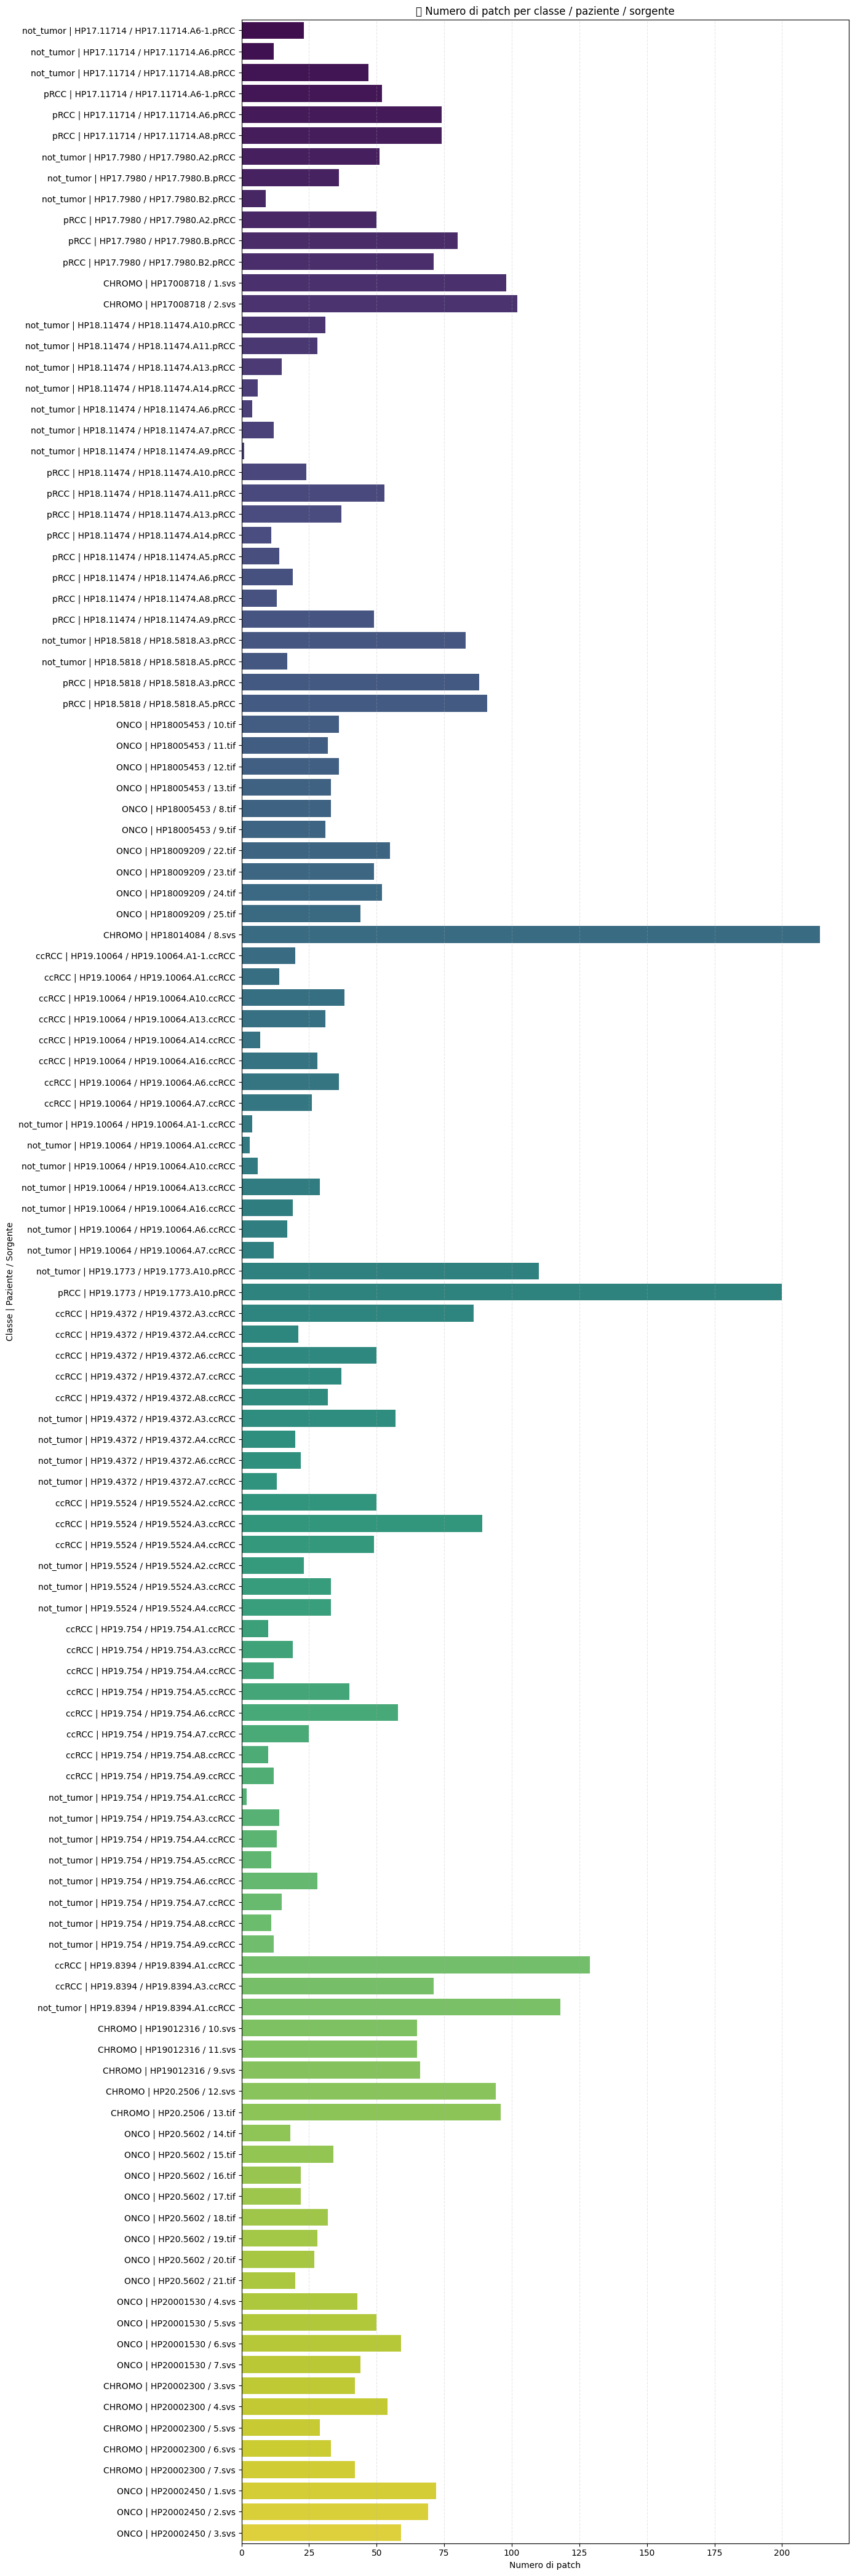

/tmp/ipython-input-26-1259853400.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, y='label', x='patch_count', palette='viridis')
/tmp/ipython-input-26-1259853400.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


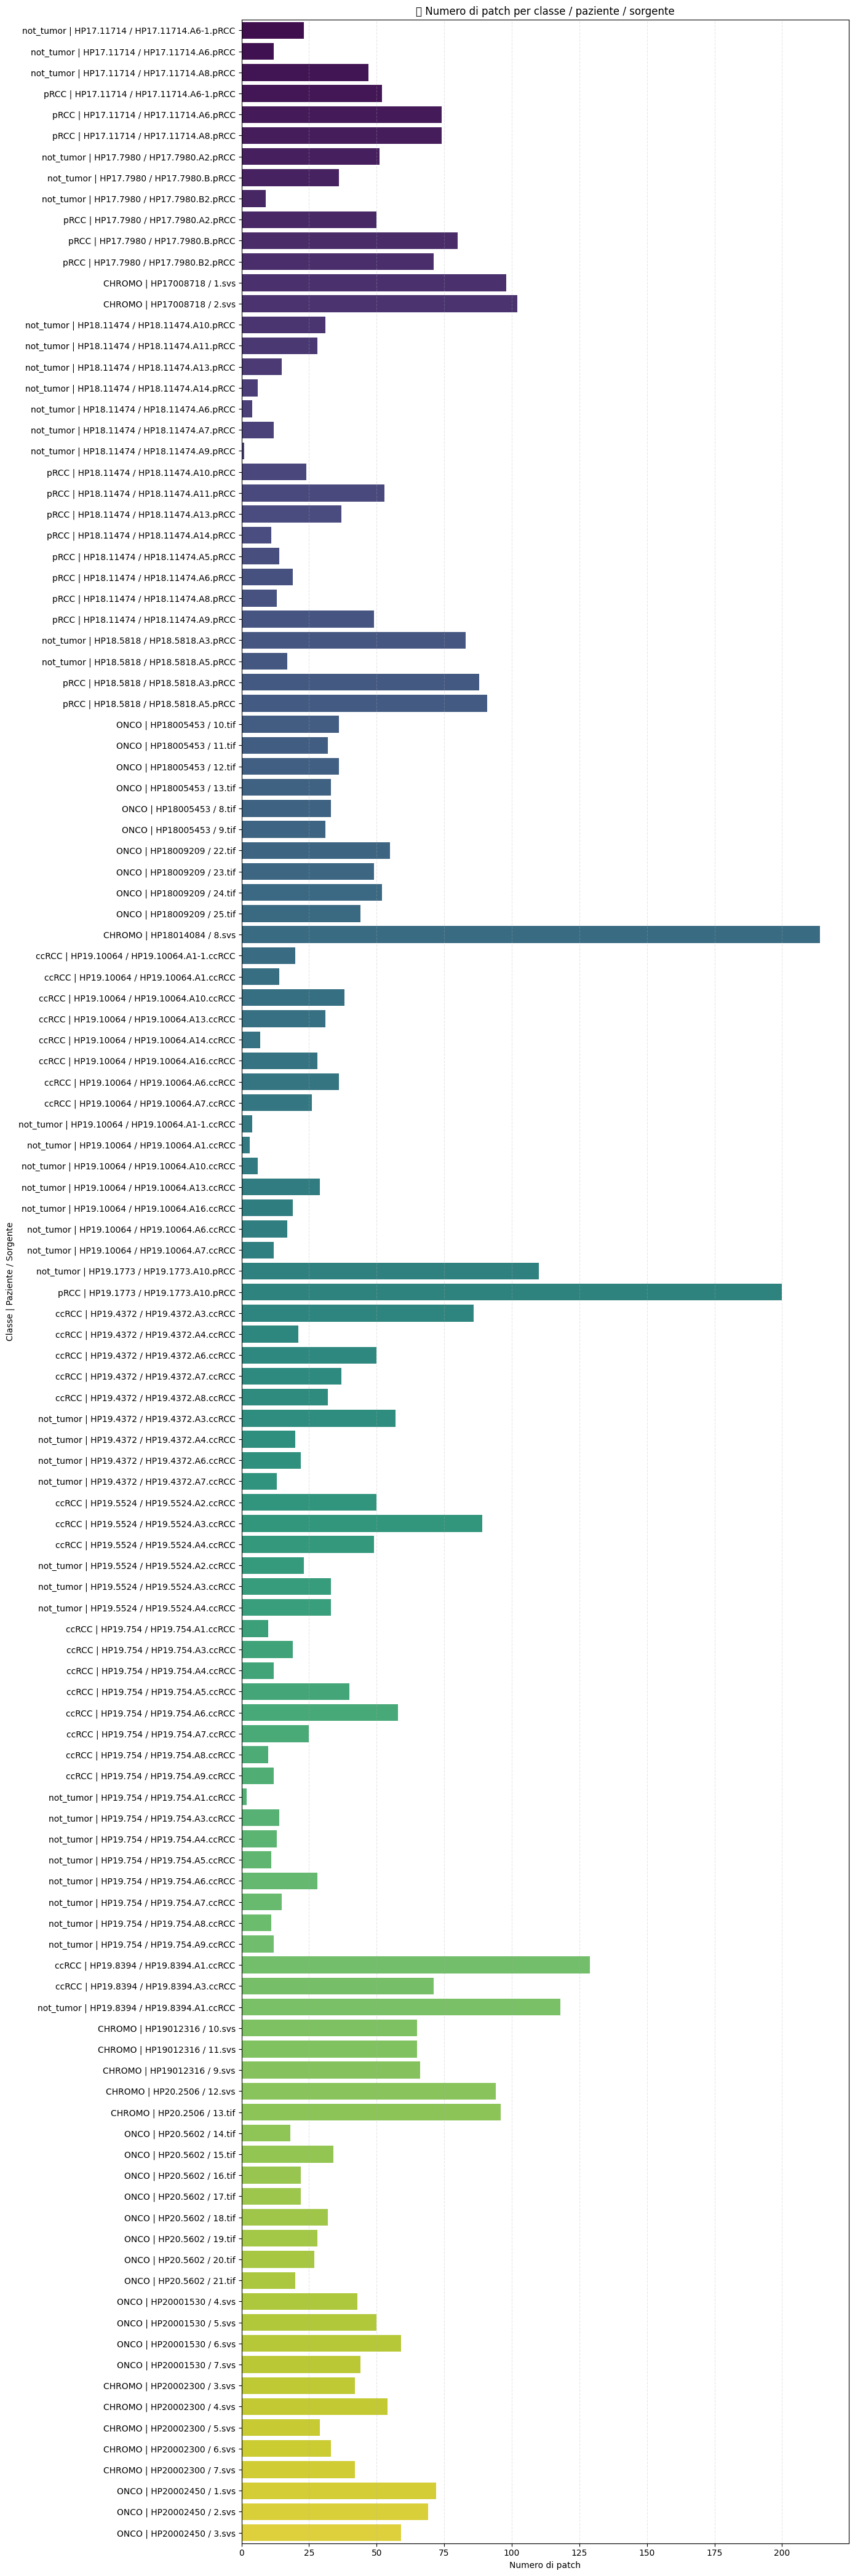

In [26]:
# Cell X – Numero di patch per paziente / classe / sorgente (WSI o ROI)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# 0) Assicuriamoci di avere le colonne necessarie
# patch_df deve contenere: patient_id, subtype, wsi_path, roi_file
assert {'patient_id','subtype'}.issubset(patch_df.columns)

# 1) Determina source_name (WSI stem oppure nome completo ROI)
def get_source_name(row):
    if pd.notna(row.get('wsi_path')):
        return Path(row['wsi_path']).stem
    if pd.notna(row.get('roi_file')):
        return Path(row['roi_file']).name
    return 'UNKNOWN'

patch_df['source_name'] = patch_df.apply(get_source_name, axis=1)

# 2) Raggruppa per patient_id, subtype, source_name e conta
counts = (
    patch_df
    .groupby(['patient_id','subtype','source_name'])
    .size()
    .reset_index(name='patch_count')
    .sort_values(['patient_id','subtype','source_name'])
)

# 3) Crea etichetta per y-axis
counts['label'] = counts['subtype'] + ' | ' + counts['patient_id'] + ' / ' + counts['source_name']

# 4) Plot
plt.figure(figsize=(14, max(4, len(counts)*0.35)))
sns.barplot(data=counts, y='label', x='patch_count', palette='viridis')

plt.title("📊 Numero di patch per classe / paziente / sorgente")
plt.xlabel("Numero di patch")
plt.ylabel("Classe | Paziente / Sorgente")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [27]:
# Cell 10 – Identify duplicated patient_ids and their subtypes
import pandas as pd

# loaded_df è il DataFrame caricato in Cell 9
# 1) Quanti patient_id totali sono duplicati (conteggio righe duplicate)
total_duplicates = loaded_df['patient_id'].duplicated().sum()
print(f"🔢 Total duplicate rows by patient_id: {total_duplicates}")

# 2) Quali patient_id compaiono in più di una riga
dupe_ids = loaded_df['patient_id'][loaded_df['patient_id'].duplicated(keep=False)].unique()
print(f"🔍 Unique patient_ids that appear multiple times: {len(dupe_ids)}\n{list(dupe_ids)}\n")

# 3) Trovo quelli che sono presenti in più di un subtype
multi = (loaded_df
         .groupby('patient_id')['subtype']
         .nunique()
         .loc[lambda x: x > 1]
         .index
        )

print("⚠️ patient_id present in multiple subtypes:")
for pid in sorted(multi):
    classes = loaded_df.loc[loaded_df['patient_id']==pid, 'subtype'].unique().tolist()
    print(f"  • {pid}: {classes}")


🔢 Total duplicate rows by patient_id: 4980
🔍 Unique patient_ids that appear multiple times: 20
['HP19.5524', 'HP19.4372', 'HP19.754', 'HP19.10064', 'HP19.8394', 'HP18.11474', 'HP17.7980', 'HP18.5818', 'HP19.1773', 'HP17.11714', 'HP18014084', 'HP20.2506', 'HP19012316', 'HP20002300', 'HP17008718', 'HP20.5602', 'HP18005453', 'HP20001530', 'HP20002450', 'HP18009209']

⚠️ patient_id present in multiple subtypes:
  • HP17.11714: ['pRCC', 'not_tumor']
  • HP17.7980: ['pRCC', 'not_tumor']
  • HP18.11474: ['pRCC', 'not_tumor']
  • HP18.5818: ['pRCC', 'not_tumor']
  • HP19.10064: ['ccRCC', 'not_tumor']
  • HP19.1773: ['pRCC', 'not_tumor']
  • HP19.4372: ['ccRCC', 'not_tumor']
  • HP19.5524: ['ccRCC', 'not_tumor']
  • HP19.754: ['ccRCC', 'not_tumor']
  • HP19.8394: ['ccRCC', 'not_tumor']
🔢 Total duplicate rows by patient_id: 4980
🔍 Unique patient_ids that appear multiple times: 20
['HP19.5524', 'HP19.4372', 'HP19.754', 'HP19.10064', 'HP19.8394', 'HP18.11474', 'HP17.7980', 'HP18.5818', 'HP19.1773'

In [28]:
# Cell 11 – Elenca le WSI utilizzate con dimensione file e dimensioni pixel
from pathlib import Path
import os
from openslide import OpenSlide

# 1) Prendi i percorsi unici delle WSI dal DataFrame
wsi_paths = sorted({p for p in patch_df['wsi_path'].dropna()})

print(f"🔢 Unique WSI slides used: {len(wsi_paths)}\n")

# 2) Stampa tabella con path, file size (bytes), width e height (px)
print(f"{'WSI Path':80} {'Size (bytes)':>12} {'Width':>6} {'Height':>6}")
for p in wsi_paths:
    path = Path(p)
    # dimensione file
    try:
        size_bytes = path.stat().st_size
    except FileNotFoundError:
        size_bytes = None

    # leggi solo l'header per ottenere dimensioni
    try:
        slide = OpenSlide(str(path))
        width, height = slide.dimensions
        slide.close()
    except Exception:
        width = height = None

    print(f"{str(path):80} {str(size_bytes):>12} {str(width):>6} {str(height):>6}")


🔢 Unique WSI slides used: 44

WSI Path                                                                         Size (bytes)  Width Height
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A1-1.ccRCC.scn   2426658640 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A1.ccRCC.scn   2344675570 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A10.ccRCC.scn   2003084070 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A13.ccRCC.scn   1747198590 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A14.ccRCC.scn    355647246 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/raw/RCC_WSIs/ccRCC/HP19.10064.A16.ccRCC.scn   1404478636 106259 306939
/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_p